# Machine Learning : Projet Real Estate

### Tree and Random Forest

##### Membres : Zakaria Kabara - Valentin Lhote - Omar Mousteau - Marijan Sorić

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
#import tensorflow as tf
import random
from sklearn.impute import KNNImputer
from tqdm import tqdm

In [98]:
X_train_path = "X_train_J01Z4CN.csv"   # Ouverture et conversion en dataframe du X d'entrainement
X_train = pd.read_csv(X_train_path)
Xfinal = pd.read_csv('X_test_BEhvxAN.csv')
X_train.shape # 5 premières lignes de la Dataframe

(37368, 27)

In [99]:
id_test = list(Xfinal['id_annonce'])

In [100]:
X_train=pd.concat([X_train, Xfinal], axis=0)

In [101]:
y_train_path = "y_train_OXxrJt1.csv"    # Ouverture et conversion en dataframe du y d'entrainement
y_train = pd.read_csv(y_train_path)
#y_train.head(5)

In [102]:
"""Création d'un unique dataframe combinant les prix et les attributs de chaque bien"""
df=X_train.copy()
df.insert(1, 'price', y_train['price'])
#df.head()

### Preprocessing

On enlève les paramètres que l'on juge moins utiles (on va utiliser lat et long au lieu de la ville/code postal).

In [103]:
df.drop(columns=['postal_code','city','energy_performance_category','ghg_category','exposition','nb_photos','energy_performance_value','ghg_value'], inplace=True)

In [104]:
df.head()

,id_annonce,price,property_type,approximate_latitude,approximate_longitude,size,floor,land_size,nb_rooms,nb_bedrooms,nb_bathrooms,nb_parking_places,nb_boxes,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors
0,35996577,355000.0,appartement,43.643880,7.117183,63.0,NaN,NaN,3.0,2.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,35811033,190000.0,appartement,45.695757,4.895610,90.0,3.0,NaN,5.0,4.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35731841,39000.0,maison,47.966791,-1.220451,61.0,NaN,370.0,2.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35886765,299000.0,maison,47.289292,-1.878805,142.0,NaN,764.0,4.0,3.0,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,35781137,478000.0,appartement,45.718992,4.844234,88.0,3.0,NaN,4.0,3.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


On fixe l'étage à 0 pour les maisons :
On fixe le land_size des appartement à la size.

In [105]:
df[df['property_type']=="maison"]=df[df['property_type']=="maison"].assign(floor=0.0)
df[df['property_type']=="maison"].loc[:,'floor']
df.loc[df['property_type']=="appartement",'land_size']=df.loc[df['property_type']=="appartement",'land_size'].fillna(0)

In [106]:
""" % de NaN par colonne du dtf avec uniquement les appartements"""
print((df[df['property_type']=="appartement"].isna().sum()*100/df[df['property_type']=="appartement"].shape[0]).sort_values(ascending=True))

id_annonce                0.000000
has_air_conditioning      0.000000
has_a_garage              0.000000
has_a_cellar              0.000000
nb_terraces               0.000000
has_a_balcony             0.000000
nb_boxes                  0.000000
nb_parking_places         0.000000
last_floor                0.000000
upper_floors              0.000000
land_size                 0.000000
approximate_longitude     0.000000
approximate_latitude      0.000000
property_type             0.000000
price                     0.000000
nb_rooms                  0.360095
size                      0.669473
nb_bedrooms               7.064969
nb_bathrooms             37.414414
floor                    38.971446
dtype: float64


On choisit, pour les appartements où le nombre de salles de bains n'est pas spécifié, de fixer ce nombre à 1.

In [107]:
df.loc[df['property_type']=="maison",'nb_bathrooms']=df.loc[df['property_type']=="maison",'nb_bathrooms'].fillna(1)
df.loc[df['property_type']=="appartement",'nb_bathrooms']=df.loc[df['property_type']=="appartement",'nb_bathrooms'].fillna(1)

<AxesSubplot:>

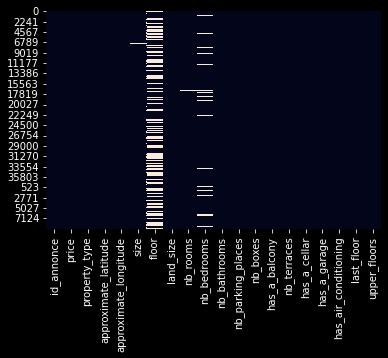

In [108]:
sns.heatmap(df[df['property_type']=="appartement"].isna(),cbar=False)

In [109]:
""" % de NaN par colonne du dtf total"""
print((df.isna().sum()*100/df.shape[0]).sort_values(ascending=True))

id_annonce                0.000000
has_air_conditioning      0.000000
has_a_garage              0.000000
has_a_cellar              0.000000
nb_terraces               0.000000
has_a_balcony             0.000000
nb_boxes                  0.000000
nb_parking_places         0.000000
last_floor                0.000000
upper_floors              0.000000
approximate_longitude     0.000000
approximate_latitude      0.000000
property_type             0.000000
price                     0.000000
size                      1.387372
nb_rooms                  4.110733
nb_bathrooms              6.609288
nb_bedrooms               7.208770
land_size                17.894534
floor                    32.003768
dtype: float64


(Peut-être ajouter d'autres spécificités sur la moyenne)

On enlève toutes les lignes avec des valeurs manquantes, cela nous permet de garder une bonne partie du dataset de départ 

### Encodage

In [110]:
df.set_index('id_annonce',inplace=True)

In [111]:
# calculer la matrice de corrélation et extraire la colonne "price"
corr_price = df.corr()['price']

# trier les corrélations par ordre croissant
corr_price_sorted = corr_price.sort_values(ascending=False)

# afficher les corrélations triées
print(corr_price_sorted)

price                    1.000000
nb_rooms                 0.241852
nb_bedrooms              0.228745
nb_bathrooms             0.140812
has_a_cellar             0.109902
nb_terraces              0.102147
floor                    0.083633
approximate_longitude    0.077580
nb_parking_places        0.050750
has_a_balcony            0.049391
has_air_conditioning     0.045045
last_floor               0.036092
has_a_garage             0.035418
land_size                0.035131
nb_boxes                 0.025608
approximate_latitude     0.025104
size                     0.024400
upper_floors            -0.002453
Name: price, dtype: float64


<AxesSubplot:>

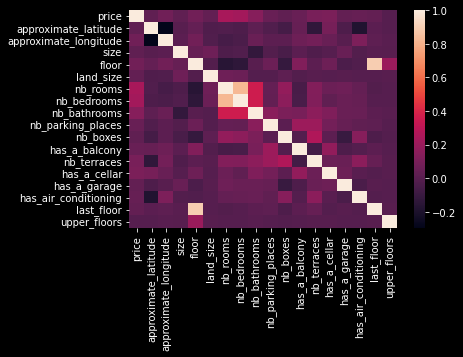

In [112]:
sns.heatmap(df.corr())

On encode les valeurs de type de propriété :

In [113]:
df=pd.get_dummies(df,columns=['property_type'])

In [114]:
df.columns

Index(['price', 'approximate_latitude', 'approximate_longitude', 'size',
       'floor', 'land_size', 'nb_rooms', 'nb_bedrooms', 'nb_bathrooms',
       'nb_parking_places', 'nb_boxes', 'has_a_balcony', 'nb_terraces',
       'has_a_cellar', 'has_a_garage', 'has_air_conditioning', 'last_floor',
       'upper_floors', 'property_type_appartement', 'property_type_atelier',
       'property_type_chalet', 'property_type_chambre',
       'property_type_château', 'property_type_divers', 'property_type_duplex',
       'property_type_ferme', 'property_type_gîte', 'property_type_hôtel',
       'property_type_hôtel particulier', 'property_type_loft',
       'property_type_maison', 'property_type_manoir', 'property_type_moulin',
       'property_type_parking', 'property_type_propriété',
       'property_type_péniche', 'property_type_terrain',
       'property_type_terrain à bâtir', 'property_type_viager',
       'property_type_villa'],
      dtype='object')

In [115]:
Xfinal = df.loc[id_test]
df.drop(index=id_test, inplace=True)

In [116]:
for i in tqdm(range(100)):
    imputer = KNNImputer(n_neighbors=5)
    imputer.fit_transform(df)
    df=df.fillna(df.mean())

100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


In [117]:
""" % de NaN par colonne du dtf total"""
print((df.isna().sum()*100/df.shape[0]).sort_values(ascending=True))

price                              0.0
property_type_château              0.0
property_type_divers               0.0
property_type_duplex               0.0
property_type_ferme                0.0
property_type_gîte                 0.0
property_type_hôtel                0.0
property_type_hôtel particulier    0.0
property_type_chambre              0.0
property_type_loft                 0.0
property_type_manoir               0.0
property_type_moulin               0.0
property_type_parking              0.0
property_type_propriété            0.0
property_type_péniche              0.0
property_type_terrain              0.0
property_type_terrain à bâtir      0.0
property_type_maison               0.0
property_type_chalet               0.0
property_type_atelier              0.0
property_type_appartement          0.0
approximate_latitude               0.0
approximate_longitude              0.0
size                               0.0
floor                              0.0
land_size                

## Modèles :

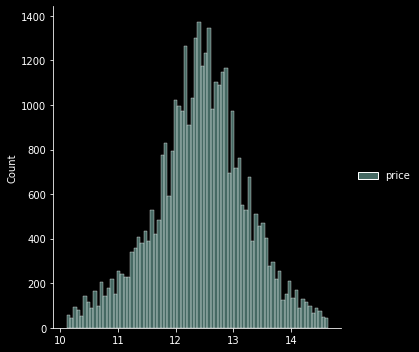

In [118]:
X = df.drop(columns=['price'])
y = y_train.copy()
y.set_index('id_annonce', inplace=True)
y = np.log(y)
sns.displot(y)

In [119]:
X.shape, y.shape

((37368, 39), (37368, 1))

In [120]:
# On split les données
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [121]:
X_train.head()

,approximate_latitude,approximate_longitude,size,floor,land_size,nb_rooms,nb_bedrooms,nb_bathrooms,nb_parking_places,nb_boxes,...,property_type_maison,property_type_manoir,property_type_moulin,property_type_parking,property_type_propriété,property_type_péniche,property_type_terrain,property_type_terrain à bâtir,property_type_viager,property_type_villa
id_annonce,,,,,,,,,,,,,,,,,,,,,
35889175,48.882232,2.414152,42.0,1.33374,0.0,2.0,1.000000,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
35795391,48.388941,1.414439,120.0,0.00000,907.0,6.0,4.000000,1.0,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0
35949091,48.293719,4.077336,221.0,1.33374,311.0,1.0,2.864877,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
36028351,49.389684,1.106909,54.0,1.33374,0.0,2.0,1.000000,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
35840223,43.777504,7.488036,54.0,4.00000,0.0,2.0,1.000000,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Trees


#### Optimized tree

L'idée est d'utiliser le GridSearchCV pour trouver les meilleurs paramètres

In [122]:
# # Paramètres à tester

# parameters = {'criterion':["squared_error", "friedman_mse", "absolute_error", "poisson"],
#               'max_depth': [None, 2, 25, 50, 100, 500, 1000]}

In [123]:
from sklearn.model_selection import GridSearchCV

# tree_1 = DecisionTreeRegressor()
# grid = GridSearchCV(tree_1, parameters)

# grid.fit(X_train, y_train)

In [124]:
# pd.DataFrame(grid.cv_results_)

In [125]:
# grid.best_params_

In [126]:
# y_pred = grid.best_estimator_.predict(X_test)

# #print('mean squared error =',mse(y_test, y_pred))
# print('mean absolute error =',mae(y_test, y_pred))
# print('r2 score =', r2_score(y_test, y_pred))

### Random Forests

In [127]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)

C:\Users\33689\AppData\Local\Temp\ipykernel_13960\3420843573.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)


KeyboardInterrupt: 

In [ ]:
for i in tqdm(range(100)):
    imputer = KNNImputer(n_neighbors=5)
    imputer.fit_transform(Xfinal)
    Xfinal=Xfinal.fillna(df.mean())

100%|██████████| 100/100 [00:05<00:00, 18.66it/s]


In [ ]:
y_pred = random_forest.predict(X_test)
y_pred = np.exp(y_pred)

y_pred.to_csv('y_solution.csv', index=True)

#print('mean squared error =',mse(y_test, y_pred))
#print('mean absolute error =',mae(y_test, y_pred))
#print('r2 score =', r2_score(y_test, y_pred))

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [128]:
from sklearn.metrics import mean_absolute_percentage_error

def custom_metric_function(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)*100

print(custom_metric_function(y_test, y_pred))

98.87530306129803


#### Random Forest with Best Params

In [ ]:
#The number of trees in the forest.
#parameters = {'n_estimators' : [25,50,100,200]} # Devient très long pour plus de 200
parameters={'bootstrap': [True, False],
 'criterion' : ['absolute_error'],
 'max_depth': [10, 50,  100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 200]}

In [ ]:
random_forest_1 = RandomForestRegressor()
grid = GridSearchCV(random_forest_1, parameters)

grid.fit(X_train, y_train)

### XGBoost

In [ ]:
#pip install xgboost

In [ ]:
#from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error

def custom_metric_function(y_true, y_pred):
    return mean_absolute_percentage_error(np.exp(y_true), np.exp(y_pred))*100

XGB = GradientBoostingRegressor()
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)
error = custom_metric_function(y_test, y_pred)
print('Score : '+error*100+'%')

TypeError: cannot unpack non-iterable bool object

In [ ]:
y_train.to_csv('my_data.csv', index=True)

In [ ]:
X_train=pd.DataFrame(X_train, dtype='float64')

In [ ]:
import xgboost as xgb
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 200, 300],
           'colsample_bytree': [0.3, 0.7]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, y_train)


In [ ]:
y_pred = clf.predict(X_test)
print('mean absolute error =',mae(y_test, y_pred))
print('r2 score =', r2_score(y_test, y_pred))

In [ ]:
clf.best_params_

In [ ]:
y_pred=clf.best_estimator_.predict(X_test)

print(custom_metric_function(y_test, y_pred))

# Deep learning

In [129]:
# On split les données
from sklearn.model_selection import train_test_split

import tensorflow as tf
# 0n importe tout ce qu'on a besoin pour le reseau
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras import activations


#On normalise tout et on garde les valeurs pour l'affichage
delta = df['price'].min()
sigma = df['price'].max() - df['price'].min()
#A la fin on remultplie par sigma et on ajoute mu aux données prédites pour revenir aux prix
normalized_df=(df-df.min())/(df.max()-df.min())


X = normalized_df.drop(columns=['price'])
y = normalized_df['price']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2) #On découpe les données pour faire les calculs
y_test_not_normalize = y_test * sigma + delta
input_dim= len(df.columns)-1
print(y.head())

id_annonce
35996577    0.145320
35811033    0.072778
35731841    0.006390
35886765    0.120699
35781137    0.199397
Name: price, dtype: float64


Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 30)                1200      
                                                                 
 relu1 (Dense)               (None, 15)                465       
                                                                 
 output (Dense)              (None, 1)                 16        
                                                                 
Total params: 1,681
Trainable params: 1,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
468/468 [==============================] - 1s 1ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 2/250
468/468 [==============================] - 0s 1ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 3/250
468/468 [============================

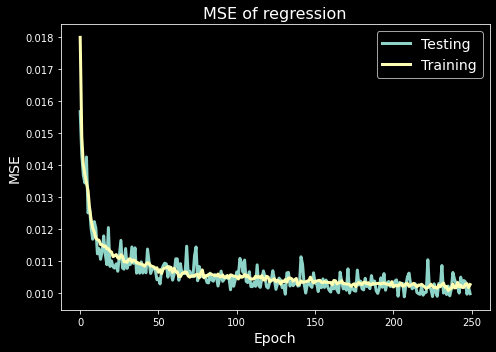

In [ ]:
model1 = Sequential()
hyp1 = {'learning_rate' : 0.01,
        'batch_size' : 64,
        'epochs' : 250}

model1.add(Dense(30, input_dim = input_dim, name = 'Input'))
model1.add(Dense(15,activation = 'relu', name='relu1'))
model1.add(Dense(1,activation = 'sigmoid',name='output'))

model1.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adamax(learning_rate = hyp1['learning_rate'],),
    metrics=['mse'])

model1.summary()

history = model1.fit(X_train,y_train,
                     epochs = hyp1['epochs'],
                     batch_size = hyp1['batch_size'],
                     verbose = 1,
                     validation_data=(X_test,y_test))

score = model1.evaluate(X_test, y_test, verbose=0)
y_predict1 = model1.predict(X_test)
y_predict1 = y_predict1*sigma + delta
print("pourcentage d'erreur",custom_metric_function(y_test_not_normalize,y_predict1))
print('Test loss:', score[0])
print('Test mse:', score[1])

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['val_mse'], lw=3, label='Testing')
plt.plot(history.epoch, history.history['mse'], lw=3, label='Training')
plt.legend(fontsize=14)
plt.title('MSE of regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.tight_layout()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 30)                1200      
                                                                 
 relu1 (Dense)               (None, 15)                465       
                                                                 
 relu2 (Dense)               (None, 10)                160       
                                                                 
 relu13 (Dense)              (None, 7)                 77        
                                                                 
 output (Dense)              (None, 1)                 8         
                                                                 
Total params: 1,910
Trainable params: 1,910
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1869/1869 [=============================

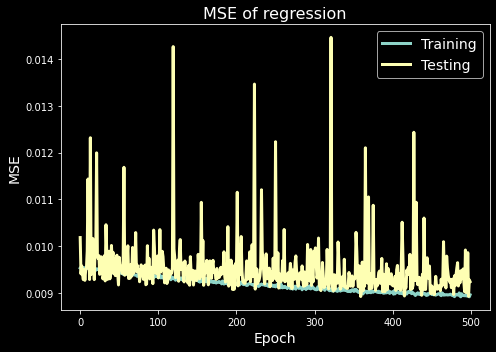

In [ ]:
model2 = Sequential()
hyp2 = {'learning_rate' : 0.01,
        'batch_size' : 16,
        'epochs' : 500}

model2.add(Dense(30, input_dim = input_dim, name = 'Input'))
model2.add(Dense(15,activation = 'relu', name='relu1'))
model2.add(Dense(10,activation = 'relu', name='relu2'))
model2.add(Dense(7,activation = 'relu', name='relu13'))
model2.add(Dense(1,activation = 'sigmoid',name='output'))

model2.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate = hyp2['learning_rate'],),
    metrics=['mse'])

model2.summary()

history = model1.fit(X_train,y_train,
                     epochs = hyp2['epochs'],
                     batch_size = hyp2['batch_size'],
                     verbose = 1,
                     validation_data=(X_test,y_test))

score = model2.evaluate(X_test, y_test, verbose=0)
y_predict2 = model2.predict(X_test)
y_predict2 = y_predict2*sigma + delta
print("pourcentage d'erreur", custom_metric_function(y_test_not_normalize,y_predict2))

print('Test loss:', score[0])
print('Test mse:', score[1])

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['mse'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_mse'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('MSE of regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.tight_layout()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 30)                1200      
                                                                 
 sigmoid1 (Dense)            (None, 15)                465       
                                                                 
 sigmoid3 (Dense)            (None, 7)                 112       
                                                                 
 output (Dense)              (None, 1)                 8         
                                                                 
Total params: 1,785
Trainable params: 1,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
468/468 [==============================] - 0s 1ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 2/50
468/468 [==============================] 

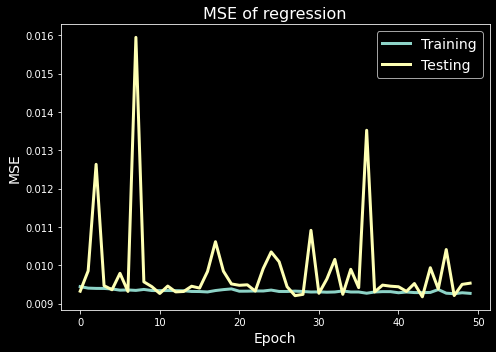

In [ ]:
model3 = Sequential()
hyp3 = {'learning_rate' : 0.1,
        'batch_size' : 64,
        'epochs' : 50}

model3.add(Dense(30, input_dim = input_dim, name = 'Input'))
model3.add(Dense(15,activation = 'sigmoid', name='sigmoid1'))
model3.add(Dense(7,activation = 'sigmoid', name='sigmoid3'))
model3.add(Dense(1,activation = 'sigmoid',name='output'))

model3.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate = hyp3['learning_rate'],),
    metrics=['mse'])

model3.summary()

history = model1.fit(X_train,y_train,
                     epochs = hyp3['epochs'],
                     batch_size = hyp3['batch_size'],
                     verbose = 1,
                     validation_data=(X_test,y_test))

score = model3.evaluate(X_test, y_test, verbose=0)
y_predict3 = model3.predict(X_test)
y_predict3 = y_predict3*sigma + delta
print("pourcentage d'erreur", custom_metric_function(y_test_not_normalize,y_predict3))

print('Test loss:', score[0])
print('Test mse:', score[1])

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['mse'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_mse'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('MSE of regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.tight_layout()

Epoch 1/50
1869/1869 [==============================] - 2s 1ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 2/50
1869/1869 [==============================] - 2s 973us/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 3/50
1869/1869 [==============================] - 2s 1ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 4/50
1869/1869 [==============================] - 2s 914us/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 5/50
1869/1869 [==============================] - 2s 943us/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 6/50
1869/1869 [==============================] - 2s 996us/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 7/50
1869/1869 [==============================] - 2s 954us/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 8/50
1869/1869 [==============================

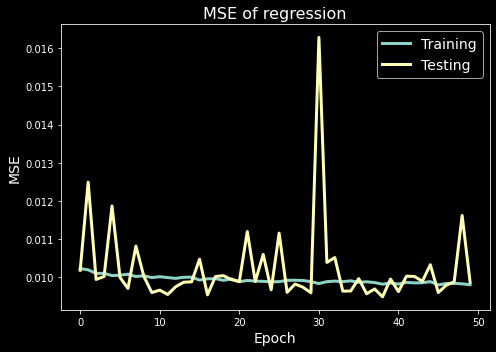

In [ ]:
model4 = Sequential()
hyp4 = {'learning_rate' : 0.1,
        'batch_size' : 16,
        'epochs' : 50}

model4.add(Dense(30, input_dim = input_dim, activation='relu', name = 'Input'))
model4.add(Dense(25,activation = 'relu', name='relu1'))
model4.add(Dense(20,activation = 'relu', name='relu2'))
model4.add(Dense(15,activation = 'relu', name='relu13'))
model4.add(Dense(10,activation = 'relu', name='relu4'))
model4.add(Dense(8,activation = 'relu', name='relu5'))
model4.add(Dense(6,activation = 'relu', name='relu16'))
model4.add(Dense(4,activation = 'relu', name='relu7'))
model4.add(Dense(3,activation = 'relu', name='relu8'))
model4.add(Dense(2,activation = 'relu', name='relu9'))
model4.add(Dense(1,activation = 'sigmoid',name='output'))

model4.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate = hyp4['learning_rate'],),
    metrics=['mse'])

#model4.summary()

history = model1.fit(X_train,y_train,
                     epochs = hyp4['epochs'],
                     batch_size = hyp4['batch_size'],
                     verbose = 1,
                     validation_data=(X_test,y_test))

score = model4.evaluate(X_test, y_test, verbose=0)
y_predict4 = model4.predict(X_test)
y_predict4 = y_predict4*sigma + delta
print("pourcentage d'erreur", custom_metric_function(y_test_not_normalize,y_predict4))

print('Test loss:', score[0])
print('Test mse:', score[1])

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['mse'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_mse'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('MSE of regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.tight_layout()

Epoch 1/50
1869/1869 [==============================] - 3s 1ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 2/50
1869/1869 [==============================] - 2s 1ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 3/50
1869/1869 [==============================] - 2s 892us/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 4/50
1869/1869 [==============================] - 2s 872us/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 5/50
1869/1869 [==============================] - 2s 1ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 6/50
1869/1869 [==============================] - 2s 930us/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 7/50
1869/1869 [==============================] - 2s 882us/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 8/50
1869/1869 [==============================] 

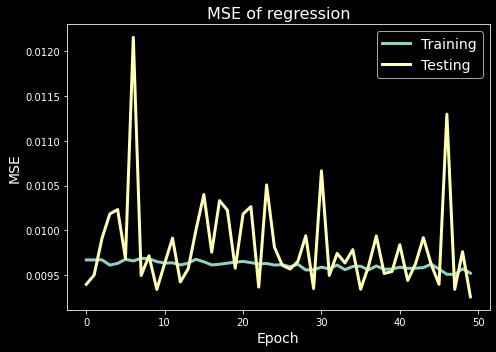

In [ ]:
model5 = Sequential()
hyp5 = {'learning_rate' : 0.001,
        'batch_size' : 16,
        'epochs' : 50}

model5.add(Dense(30, input_dim = input_dim, activation='relu', name = 'Input'))
model5.add(Dense(25,activation = 'sigmoid', name='relu1'))
model5.add(Dense(20,activation = 'sigmoid', name='relu2'))
model5.add(Dense(15,activation = 'sigmoid', name='relu3'))
model5.add(Dense(10,activation = 'sigmoid', name='relu4'))
model5.add(Dense(8,activation = 'sigmoid', name='relu5'))
model5.add(Dense(6,activation = 'sigmoid', name='relu16'))
model5.add(Dense(4,activation = 'sigmoid', name='relu7'))
model5.add(Dense(3,activation = 'sigmoid', name='relu8'))
model5.add(Dense(2,activation = 'sigmoid', name='relu9'))
model5.add(Dense(1,activation = 'sigmoid',name='output'))

model5.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate = hyp5['learning_rate'],),
    metrics=['mse'])

#model5.summary()

history = model1.fit(X_train,y_train,
                     epochs = hyp5['epochs'],
                     batch_size = hyp5['batch_size'],
                     verbose = 1,
                     validation_data=(X_test,y_test))

score = model5.evaluate(X_test, y_test, verbose=0)
y_predict5 = model5.predict(X_test)
y_predict5 = y_predict5*sigma + delta
print("pourcentage d'erreur", custom_metric_function(y_test_not_normalize,y_predict5))

print('Test loss:', score[0])
print('Test mse:', score[1])

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['mse'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_mse'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('MSE of regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.tight_layout()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 39)                1560      
                                                                 
 output (Dense)              (None, 1)                 40        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
117/117 [==============================] - 1s 2ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 2/10000
117/117 [==============================] - 0s 1ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 3/10000
117/117 [==============================] - 0s 1ms/step - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 4/10000
117/117 [====================

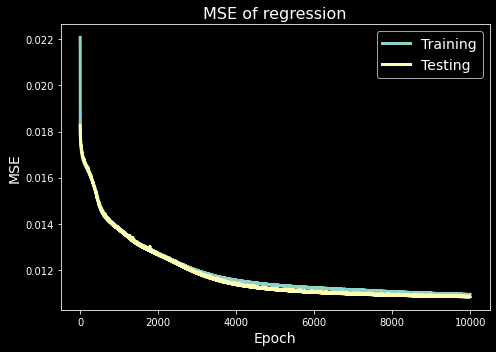

In [ ]:
model6 = Sequential()
hyp6 = {'learning_rate' : 0.2,
        'batch_size' : 256,
        'epochs' : 10000}

model6.add(Dense(input_dim, input_dim = input_dim,activation='sigmoid', name = 'Input'))
model6.add(Dense(1,activation = 'sigmoid',name='output'))

model6.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate = hyp6['learning_rate'],),
    metrics=['mse'])

model6.summary()

history = model6.fit(X_train,y_train,
                     epochs = hyp6['epochs'],
                     batch_size = hyp6['batch_size'],
                     verbose = 1,
                     validation_data=(X_test,y_test))

score = model6.evaluate(X_test, y_test, verbose=0)
y_predict6 = model6.predict(X_test)
y_predict6 = y_predict6*sigma + delta
print("pourcentage d'erreur",custom_metric_function(y_test_not_normalize,y_predict6))
print('Test loss:', score[0])
print('Test mse:', score[1])

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['mse'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_mse'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('MSE of regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.tight_layout()

Réseaux 7 à ? : comparaison des techniques de convergences

234/234 [==============================] - 0s 833us/step
Optimizer: Adagrad
pourcentage d'erreur 96.0660547392835
Test loss: 0.014988124370574951
Test mse: 0.014988124370574951
234/234 [==============================] - 0s 821us/step
Optimizer: Adamax
pourcentage d'erreur 66.47685727377491
Test loss: 0.010956160724163055
Test mse: 0.010956160724163055
234/234 [==============================] - 0s 938us/step
Optimizer: Adadelta
pourcentage d'erreur 99.86440892389913
Test loss: 0.01666957698762417
Test mse: 0.01666957698762417
234/234 [==============================] - 0s 942us/step
Optimizer: Nadam
pourcentage d'erreur 67.41567933810416
Test loss: 0.014883799478411674
Test mse: 0.014883799478411674
234/234 [==============================] - 0s 847us/step
Optimizer: Ftrl
pourcentage d'erreur 97.21553390373317
Test loss: 0.01683177798986435
Test mse: 0.01683177798986435
234/234 [==============================] - 0s 908us/step
Optimizer: Adam
pourcentage d'erreur 95.56245094160548
Test los

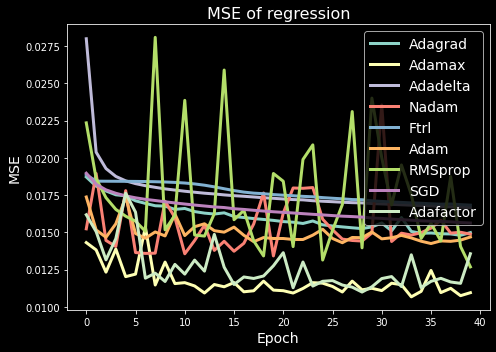

In [ ]:
optimizers = [tf.keras.optimizers.Adagrad,tf.keras.optimizers.Adamax,tf.keras.optimizers.Adadelta,tf.keras.optimizers.Nadam,
              tf.keras.optimizers.Ftrl,tf.keras.optimizers.Adam,tf.keras.optimizers.RMSprop,tf.keras.optimizers.SGD,tf.keras.optimizers.experimental.Adafactor]
noms_opti = ['Adagrad','Adamax','Adadelta','Nadam','Ftrl','Adam','RMSprop','SGD','Adafactor']

plt.figure(figsize=(7, 5))
for i in range(9):
    opti = optimizers[i]
    nom_opti = noms_opti[i]

    model7 = Sequential()
    hyp7 = {'learning_rate' : 0.05,
            'batch_size'    : 64,
            'epochs'        : 40}

    model7.add(Dense(30, input_dim = input_dim, name = 'Input'))
    model7.add(Dense(15,activation = 'relu', name='relu1'))
    model7.add(Dense(1,activation = 'sigmoid',name='output'))

    model7.compile(
        loss="mean_squared_error",
        optimizer=opti(learning_rate = hyp7['learning_rate']),
        metrics=['mse'])

    #model7.summary()

    history = model7.fit(X_train,y_train,
                        epochs = hyp7['epochs'],
                        batch_size = hyp7['batch_size'],
                        verbose = 0,
                        validation_data=(X_test,y_test))

    score = model7.evaluate(X_test, y_test, verbose=0)
    y_predict7 = model7.predict(X_test)
    y_predict7 = y_predict7*sigma + delta
    print('Optimizer:', nom_opti)
    print("pourcentage d'erreur",custom_metric_function(y_test_not_normalize,y_predict7))
    print('Test loss:', score[0])
    print('Test mse:', score[1])
    plt.plot(history.epoch, history.history['val_mse'], lw=3, label=nom_opti)

#plt.plot(history.epoch, history.history['val_mse'], lw=3, label='Testing')
#plt.plot(history.epoch, history.history['mse'], lw=3, label='Training')
plt.legend(fontsize=14)
plt.title('MSE of regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.tight_layout()

Réseau 8 : réseau 1 avec adafactor

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 30)                1200      
                                                                 
 relu1 (Dense)               (None, 15)                465       
                                                                 
 output (Dense)              (None, 1)                 16        
                                                                 
Total params: 1,681
Trainable params: 1,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
468/468 [==============================] - 2s 2ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 2/250
468/468 [==============================] - 1s 1ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 3/250
468/468 [============================

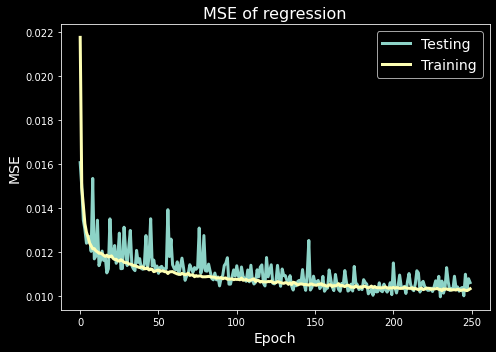

In [ ]:
model8 = Sequential()
hyp8 = {'learning_rate' : 0.01,
        'batch_size' : 64,
        'epochs' : 250}

model8.add(Dense(30, input_dim = input_dim, name = 'Input'))
model8.add(Dense(15,activation = 'relu', name='relu1'))
model8.add(Dense(1,activation = 'sigmoid',name='output'))

model8.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.experimental.Adafactor(learning_rate = hyp8['learning_rate'],),
    metrics=['mse'])

model8.summary()

history = model8.fit(X_train,y_train,
                     epochs = hyp8['epochs'],
                     batch_size = hyp8['batch_size'],
                     verbose = 1,
                     validation_data=(X_test,y_test))

score = model8.evaluate(X_test, y_test, verbose=0)
y_predict8 = model1.predict(X_test)
y_predict8 = y_predict8*sigma + delta
print("pourcentage d'erreur",custom_metric_function(y_test_not_normalize,y_predict8))
print('Test loss:', score[0])
print('Test mse:', score[1])

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['val_mse'], lw=3, label='Testing')
plt.plot(history.epoch, history.history['mse'], lw=3, label='Training')
plt.legend(fontsize=14)
plt.title('MSE of regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.tight_layout()

Reseau 9 : Adafactor, batch_size = 32,64,128,256
Petit réseau

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 10)                400       
                                                                 
 sigmoid (Dense)             (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
234/234 [==============================] - 0s 726us/step
pourcentage d'erreur 74.78248883892047
Test loss: 0.010637045837938786
Test mse: 0.010637045837938786
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inpu

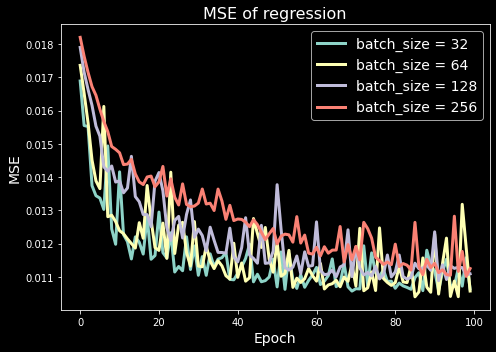

In [ ]:
plt.figure(figsize=(7, 5))
for i in range(5,9):
    model9 = Sequential()
    hyp9 = {'learning_rate' : 0.01,
            'batch_size' : 2**i,
            'epochs' : 100}

    model9.add(Dense(10, input_dim = input_dim,activation = 'sigmoid', name = 'Input'))
    model9.add(Dense(5,activation = 'sigmoid', name='sigmoid'))
    model9.add(Dense(1,activation = 'sigmoid',name='output'))

    model9.compile(
        loss="mean_squared_error",
        optimizer=tf.keras.optimizers.experimental.Adafactor(learning_rate = hyp9['learning_rate'],),
        metrics=['mse'])

    #model9.summary()

    history = model9.fit(X_train,y_train,
                        epochs = hyp9['epochs'],
                        batch_size = hyp9['batch_size'],
                        verbose = 0,
                        validation_data=(X_test,y_test))

    score = model9.evaluate(X_test, y_test, verbose=0)
    y_predict9 = model9.predict(X_test)
    y_predict9 = y_predict9*sigma + delta
    print("pourcentage d'erreur",custom_metric_function(y_test_not_normalize,y_predict9))
    print('Test loss:', score[0])
    print('Test mse:', score[1])
    plt.plot(history.epoch, history.history['val_mse'], lw=3, label='batch_size = {}'.format(str(2**i)))

#plt.plot(history.epoch, history.history['mse'], lw=3, label='Training')
plt.legend(fontsize=14)
plt.title('MSE of regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.tight_layout()

Reseaux 10 : K couches de relu

234/234 [==============================] - 0s 701us/step
pourcentage d'erreur 84.65751978500658
10 1
Test loss: 0.011911453679203987
Test mse: 0.011911453679203987
234/234 [==============================] - 0s 498us/step
pourcentage d'erreur 61.5609104626199
10 2
Test loss: 0.01014766562730074
Test mse: 0.01014766562730074
234/234 [==============================] - 0s 595us/step
pourcentage d'erreur 104.51444834130976
10 3
Test loss: 0.01297774724662304
Test mse: 0.01297774724662304
234/234 [==============================] - 0s 847us/step
erreur pour : 10 4
10 4
Test loss: nan
Test mse: nan
234/234 [==============================] - 0s 775us/step
pourcentage d'erreur 60.23053031674848
10 5
Test loss: 0.010417195037007332
Test mse: 0.010417195037007332
234/234 [==============================] - 0s 811us/step
erreur pour : 10 6
10 6
Test loss: nan
Test mse: nan
234/234 [==============================] - 0s 921us/step
erreur pour : 10 7
10 7
Test loss: nan
Test mse: nan
234/234 [=========

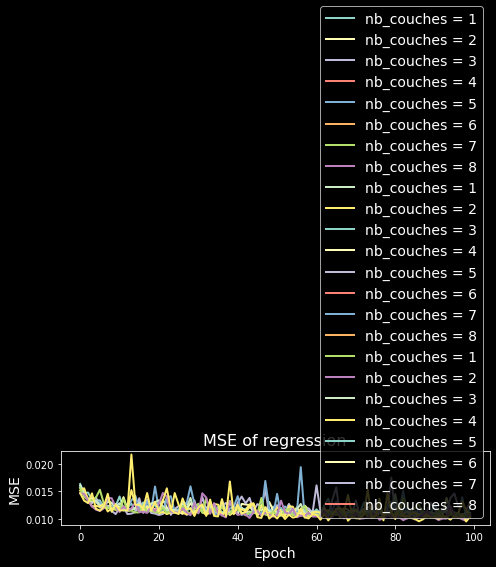

In [135]:
plt.figure(figsize=(7, 5))
from time import time
pers = [[],[],[]]
persi = [[],[],[]]
times = [[],[],[]]
for c in [10,20,30]:
    for i in range(1,9):
        T = time()
        model10 = Sequential()
        hyp10 = {'learning_rate' : 0.01,
                'batch_size' : 64,
                'epochs' : 100}

        model10.add(Dense(c, input_dim = input_dim,activation = 'relu', name = 'Input'))

        for k in range(i-1):
            model10.add(Dense(c,activation = 'relu'))

        model10.add(Dense(1,activation = 'sigmoid', name = 'Output'))


        model10.compile(
            loss="mean_squared_error",
            optimizer=tf.keras.optimizers.experimental.Adafactor(learning_rate = hyp10['learning_rate'],),
            metrics=['mse'])

        #model10.summary()

        history = model10.fit(X_train,y_train,
                            epochs = hyp10['epochs'],
                            batch_size = hyp10['batch_size'],
                            verbose = 0,
                            validation_data=(X_test,y_test))

        score = model10.evaluate(X_test, y_test, verbose=0)
        y_predict10 = model10.predict(X_test)
        y_predict10 = y_predict10*sigma + delta
        try:
            per = custom_metric_function(y_test_not_normalize,y_predict10)
            
        except ValueError:
            print('erreur pour :', c, i)
        else:
            pers[c//10-1].append(per)
            persi[c//10-1].append(i)
            print("pourcentage d'erreur",per)
        print(c, i)
        print('Test loss:', score[0])
        print('Test mse:', score[1])
        plt.plot(history.epoch, history.history['val_mse'], lw=2, label='nb_couches = {}'.format(str(i)))
        model10 = 0
        times[c//10-1].append(time()-T)



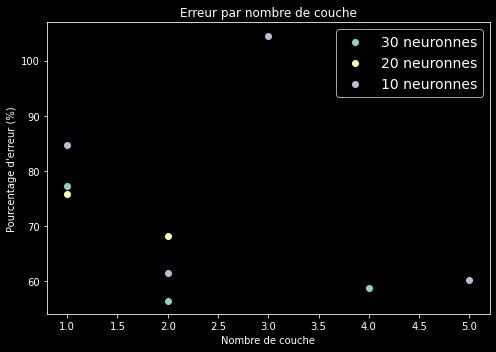

In [147]:
plt.figure(figsize=(7, 5))
plt.scatter(persi[2],pers[2],label='30 neuronnes',marker='o')
plt.scatter(persi[1],pers[1],label='20 neuronnes',marker='o')
plt.scatter(persi[0],pers[0],label='10 neuronnes',marker='o')
plt.title("Erreur par nombre de couche")
plt.xlabel("Nombre de couche")
plt.ylabel("Pourcentage d'erreur (%)")
plt.tight_layout()
plt.legend(fontsize=14)

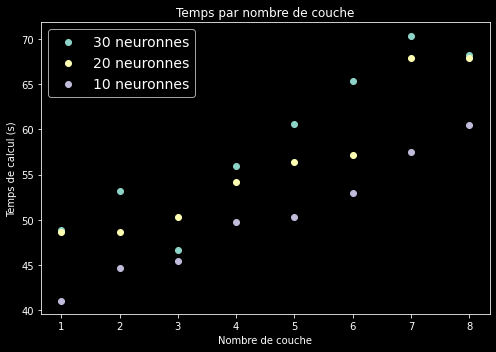

In [148]:
plt.figure(figsize=(7, 5))
plt.scatter(range(1,9),times[2],label='30 neuronnes',marker='o')
plt.scatter(range(1,9),times[1],label='20 neuronnes',marker='o')
plt.scatter(range(1,9),times[0],label='10 neuronnes',marker='o')
plt.title("Temps par nombre de couche")
plt.xlabel("Nombre de couche")
plt.ylabel("Temps de calcul (s)")
plt.legend(fontsize=14)
plt.tight_layout()

# Comparaison modèles

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error as mae
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from lightgbm import LGBMRegressor

In [ ]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror'))]
#          ("LightGBM", LGBMRegressor())]

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
for name, regressor in models:
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    error = custom_metric_function(y_test, y_pred)
    print('MAE for {reg} = {score_mae}'.format(reg=name, score_mae=str(error)))

MAE for LR = 51599814906.43
MAE for Ridge = 173.72231897520416
MAE for Lasso = 324.80640289537746
MAE for ElasticNet = 324.80640289537746
MAE for KNN = 100.48938695496305
MAE for CART = 82.22359754785842
MAE for RF = 78.01515581660516
MAE for SVR = 245.2674946179779
MAE for GBM = 109.2693768186207
MAE for XGBoost = 77.47921111115663


# Test Final

In [ ]:
for city in villes:
    Xfinal[(Xfinal['property_type']=='appartement') & (Xfinal['city'] == city)][nan_autre] = Xfinal[(Xfinal['property_type']=='appartement')& (Xfinal['city'] == city)][nan_autre].fillna(Xfinal[(Xfinal['property_type']=='appartement') & (Xfinal['city']==city)][nan_autre].mean())
    Xfinal[(Xfinal['property_type']=='appartement') & (Xfinal['city'] == city)][nan_autre].fillna(Xfinal[Xfinal['property_type']=='appartement'][nan_autre].mean())

NameError: name 'villes' is not defined

In [ ]:
for parametre in nan_autre:
    default_ = pd.DataFrame(Xfinal[Xfinal['property_type']=='appartement'])[parametre].mean()
    for city in villes:
            Xfinal.loc[(Xfinal['property_type']=='appartement') & (Xfinal['city'] == city),parametre] = Xfinal.loc[(Xfinal['property_type']=='appartement') & (Xfinal['city'] == city),parametre].fillna(pd.DataFrame(Xfinal[(Xfinal['property_type']=='appartement') & (Xfinal['city']==city)].groupby('city').mean())[parametre])
            Xfinal.loc[(Xfinal['property_type']=='appartement') & (Xfinal['city'] == city),parametre].fillna(default_)

In [ ]:
Xfinal.drop(columns=['city'],inplace=True)

In [ ]:
Xfinal.head()

### Encodage

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# instancier l'objet scaler
scaler = MinMaxScaler()
#df.drop('col2', axis=1).columns.tolist()
# normaliser les colonnes du dataframe
DF = pd.DataFrame(scaler.fit_transform(Xfinal.drop('property_type', axis=1)), columns=Xfinal.drop('property_type', axis=1).columns.tolist()).set_index(Xfinal.index)

In [ ]:
D = pd.concat([DF, pd.DataFrame(Xfinal.property_type)], axis=1)

In [ ]:
D

In [ ]:
Xfinal = D.copy()

On encode les valeurs de type de propriété :

In [ ]:
Xfinal=pd.get_dummies(Xfinal,columns=['property_type'])

In [ ]:
Xfinal

In [ ]:
Xfinal.columns

In [ ]:
y_pred_final=clf.best_estimator_.predict(Xfinal)